Данные о постах, коментариях к ним и информация об авторах загружена в БД
Облако слов топ 20 (с лематизацией)


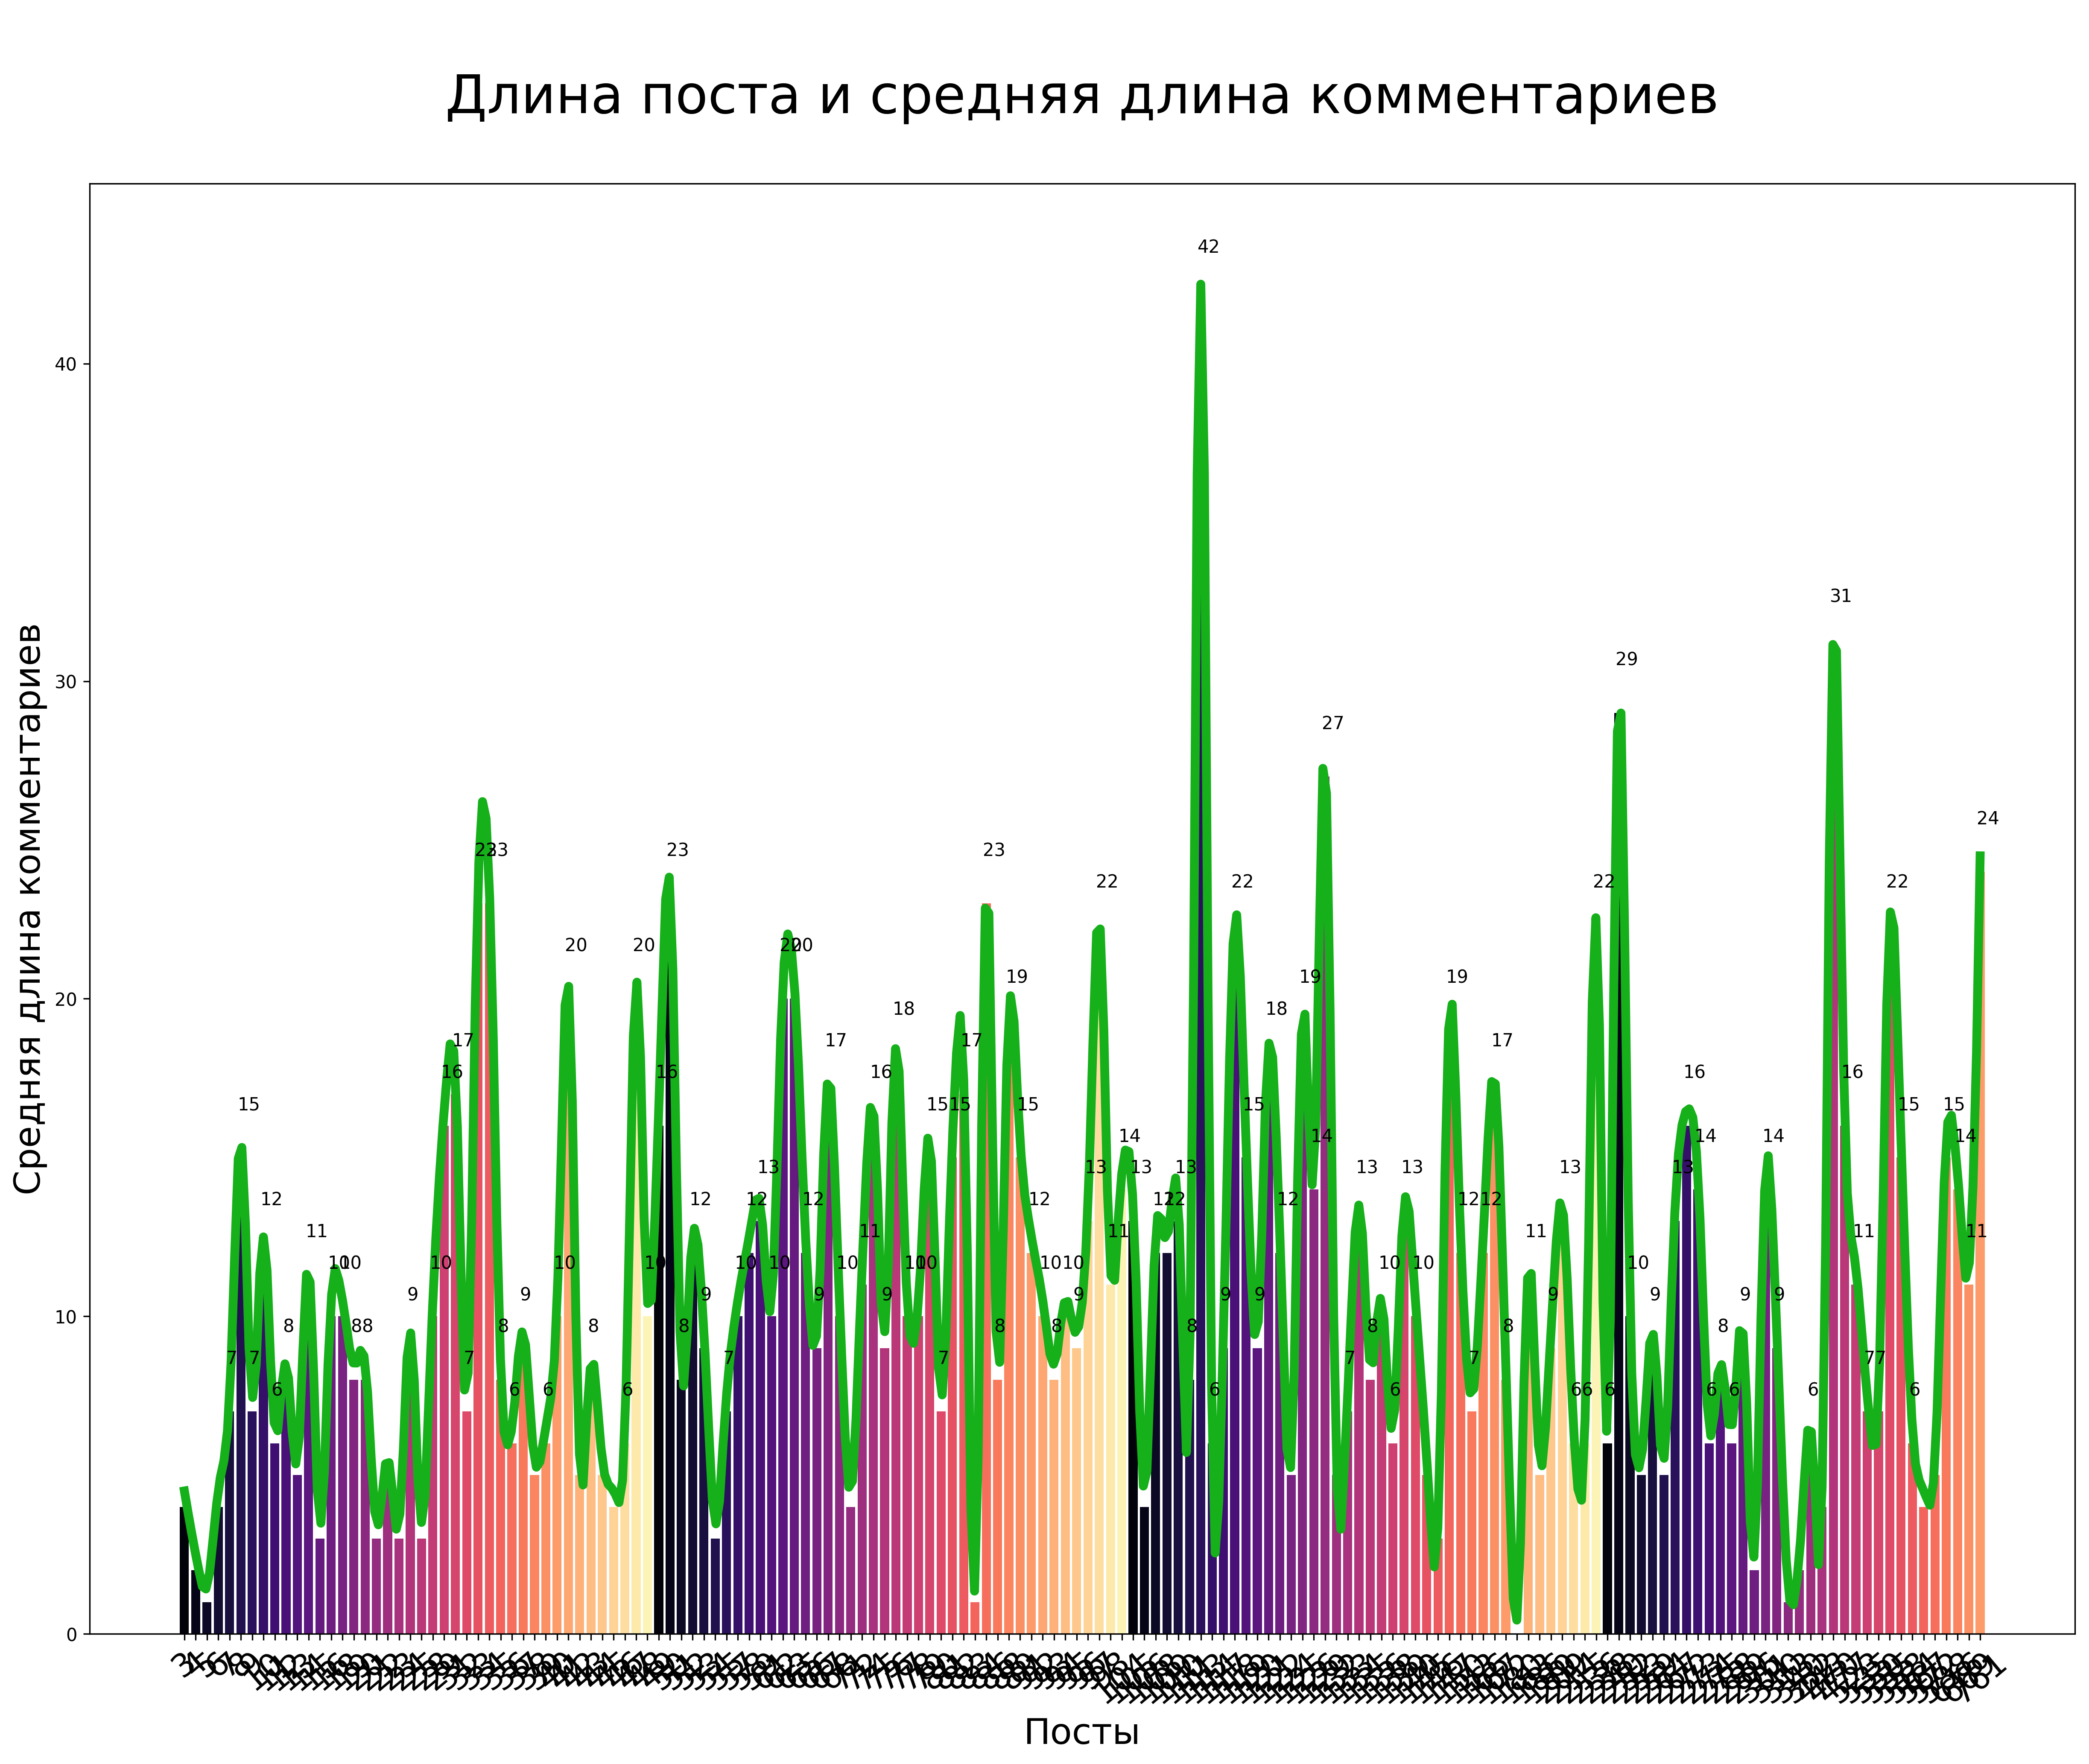

<Figure size 432x288 with 0 Axes>

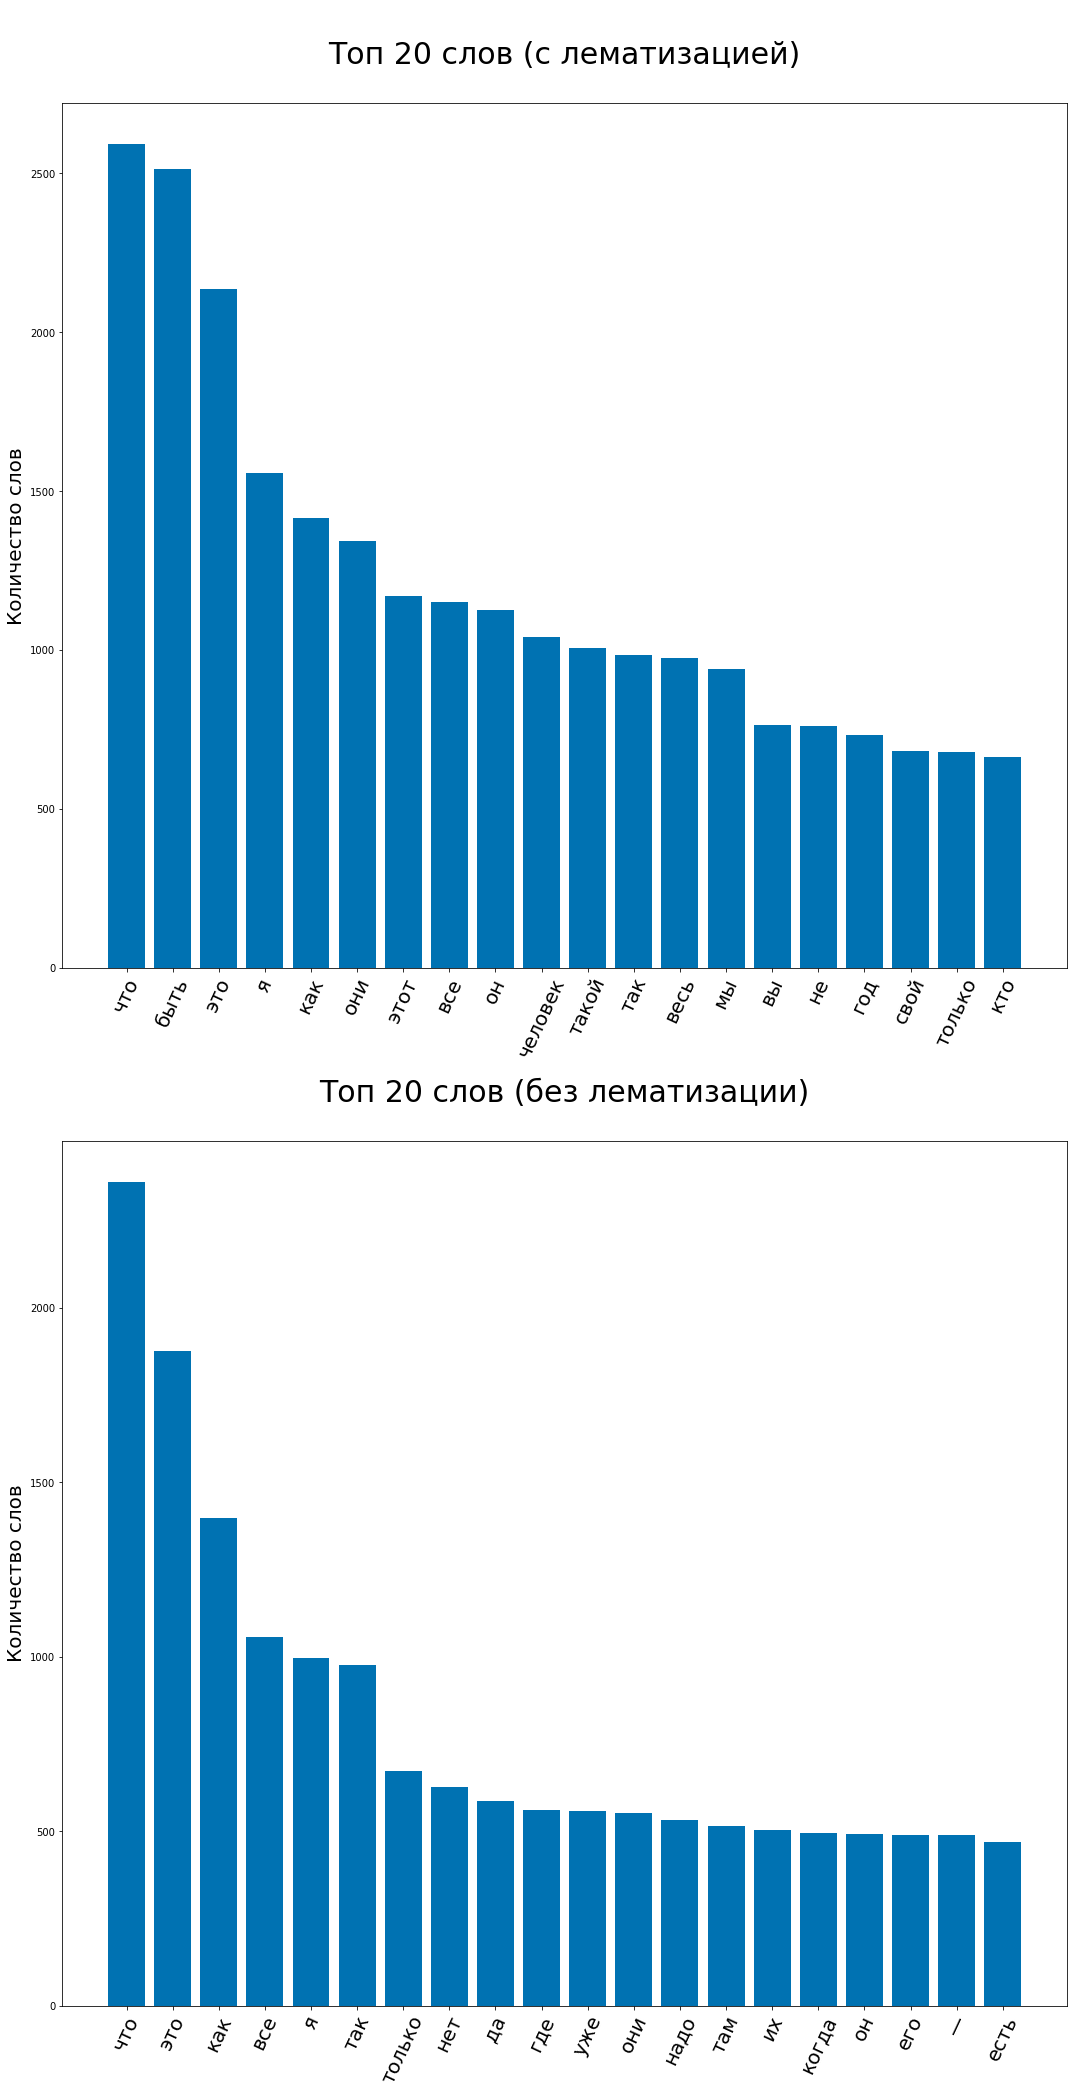

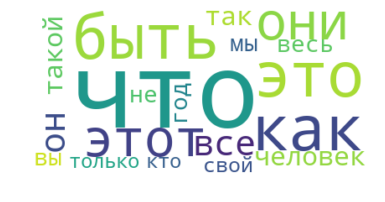

In [4]:
from datetime import datetime
from pymystem3 import Mystem
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import style
from scipy.interpolate import interp1d
from wordcloud import WordCloud
import seaborn as sns
import numpy as np
import spbdatabase as db
import w_vk_api as vk
style.use('seaborn-colorblind')

symbols = ['!', '@', '#', '$', '%', '.', '+', '?',
           ',', '"', '[', ']', '|', '/', ':', ';', ')', '(', '\n']
stopwords = db.getStopWords()
mystem = Mystem()
wordsDict = {}
wordsDictLemm = {}
post_to_coms = {}
db.create_database()


def work_wth_text(text):
    for symbol in symbols:
        if symbol in text:
            text = text.replace(symbol, ' ')
    return text


def lemmatize(text):
    lemmas = mystem.lemmatize(text)

    for lemma in lemmas:
        if '\n' in lemma or ' ' in lemma or '-' in lemma:
            lemmas.remove(lemma)
    for lemma in lemmas:
        for stword in stopwords:
            if stword == lemma:
                lemmas.remove(lemma)

    return lemmas


posts = vk.getPosts()
# Получаем id сообщества из поста (ранее был известен только domain)
owner_id = posts[0]['owner_id']

for post in posts:
    post['comments'] = vk.getComments(post['id'], owner_id)

for item in posts:
    item_to_save = {'id': item['id']}

    text = item['text']
    if text == '' and item.get('copy_history') is not None:
        text = item['copy_history'][0]['text']

    item_to_save['text'] = text

    text = work_wth_text(text)
    lemmas = lemmatize(text)

    item_to_save['lemm'] = ' '.join(lemmas)
    item_to_save['comments'] = []

    post_size = len(lemmas)
    totl_com_size = 0

    for comment in item['comments']:
        if comment.get('from_id') is not None:
            user_id = comment['from_id']
        else:
            item['comments'].remove(comment)
            continue
        com_to_save = {'user_id': user_id}
        com_to_save['id'] = comment['id']
        com_to_save['post_id'] = comment['post_id']
        com_text = comment['text']
        com_to_save['text'] = com_text

        com_text = work_wth_text(com_text)
        com_lemmas = lemmatize(com_text)
        com_to_save['lemm'] = ' '.join(com_lemmas)

        totl_com_size += len(com_lemmas)
        com_text = com_text.lower()
        for word in com_text.split(' '):
            if wordsDict.get(word) is None:
                wordsDict[word] = 1
            else:
                wordsDict[word] += 1

        for lemma in com_lemmas:
            if wordsDictLemm.get(lemma) is None:
                wordsDictLemm[lemma] = 1
            else:
                wordsDictLemm[lemma] += 1

        user = vk.getUserInfo(user_id)

        com_to_save['user_sex'] = user['sex']
        com_to_save['user_city'] = user['city']
        com_to_save['user_age'] = user['age']

        item_to_save['comments'].append(com_to_save)

    if len(item['comments']) > 0:
        avg_com_size = totl_com_size // len(item['comments'])
    else:
        avg_com_size = 0
    post_to_coms[post_size] = avg_com_size

    db.add_post(item_to_save)
    text = text.lower()
    for word in text.split(' '):
        if wordsDict.get(word) is None:
            wordsDict[word] = 1
        else:
            wordsDict[word] += 1

    for lemma in lemmas:
        if wordsDictLemm.get(lemma) is None:
            wordsDictLemm[lemma] = 1
        else:
            wordsDictLemm[lemma] += 1

print('Данные о постах, коментариях к ним и информация '
      'об авторах загружена в БД')

if wordsDict.get('') is not None:
    wordsDict.pop('')
if wordsDict.get('-') is not None:
    wordsDict.pop('-')
for stword in stopwords:
    if wordsDict.get(stword) is not None:
        wordsDict.pop(stword)

coms = [p[1] for p in sorted(post_to_coms.items(
), key=lambda x: x[0], reverse=False)]  # данные по оси y
psts = sorted([ps for ps in post_to_coms])  # подписи по оси x
x = range(len(psts))  # данные по оси x

colors = sns.color_palette('magma', max(coms))

# кривая со сглаживанием поверх барплота (необязательно)
f = interp1d(x, [x+0.5 for x in coms], kind='quadratic')
x_new = np.linspace(x[0], len(x) - 1, 501)  # тут нужны min и max по оси x
y_smooth = f(x_new)


plt.figure(figsize=(20, 15), dpi=300)
plt.bar(x, coms, color=colors)
plt.plot(x_new, y_smooth, c='xkcd:green', linewidth='5')


# рисуем точки максимумов (условных)
for a, b in zip(x, coms):
    if b > 5:
        plt.scatter(a, b+1.5, s=0)
        plt.text(a-0.3, b+1.5, str(b))


plt.title('\nДлина поста и средняя длина комментариев\n',
          fontsize=30, color='black')
plt.ylabel('Средняя длина комментариев',  fontsize=20)
plt.xlabel('Посты',  fontsize=20)
plt.xticks(x, psts, rotation=40, fontsize=18)
plt.savefig('first_chart.png', format='png', dpi=100)
plt.show()
plt.clf()


list_d = list(wordsDictLemm.items())
list_d.sort(key=lambda i: i[1], reverse=True)

objects = []
values = []
counter = 0
for item in list_d:
    if counter >= 20:
        break
    counter += 1
    objects.append(item[0])
    values.append(item[1])

y_pos = np.arange(len(objects))

fig, (ax1, ax2) = plt.subplots(
    nrows=2, ncols=1,
    figsize=(18, 35)
)

ax1.bar(
    y_pos,
    values
)
ax1.set_xticks(y_pos)
ax1.set_xticklabels(objects, rotation=65, fontsize=20)
ax1.set_ylabel('Количество слов', fontsize=20)
ax1.set_title('\nТоп 20 слов (с лематизацией)\n', fontsize=30, color='black')

cloud = WordCloud(background_color="white", max_words=2000)
cloud.generate(' '.join(objects))

list_d = list(wordsDict.items())
list_d.sort(key=lambda i: i[1], reverse=True)

objects = []
values = []
counter = 0
for item in list_d:
    if counter >= 20:
        break
    counter += 1
    objects.append(item[0])
    values.append(item[1])

y_pos = np.arange(len(objects))

ax2.bar(
    y_pos,
    values
)

ax2.set_xticks(y_pos)
ax2.set_xticklabels(objects, rotation=65, fontsize=20)
ax2.set_ylabel('Количество слов', fontsize=20)
ax2.set_title('\n\n\n\nТоп 20 слов (без лематизации)\n',
              fontsize=30, color='black')

plt.savefig('second_chart.png', format='png', dpi=100)
plt.show()
plt.clf()

print('Облако слов топ 20 (с лематизацией)')
plt.imshow(cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

cloud.to_file("post_cloud.png")
